# Scatter Plot: Time vs Tokens by Task & Status
This notebook isolates the scatter plot logic from `data_to_tex.ipynb` to visualize latency vs. total token consumption for each processor task (Data Processor, Model Converter, Sketch Generator), distinguishing success and failure runs.

In [30]:
# 1. Imports and Path Setup
import os, re
from typing import Tuple, Dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

# Determine directories relative to this notebook
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
# date inferred from parent directory name (same convention as original)
date = os.path.basename(parent_dir)

# Default data directory (processed_data within parent)
data_dir = os.path.join(parent_dir, "processed_data")

# Directory to save figures
save_dir = os.path.join(parent_dir, "tex")
os.makedirs(save_dir, exist_ok=True)

print(f"Using data_dir: {data_dir}")
print(f"Saving figures to: {save_dir}")

Using data_dir: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/processed_data
Saving figures to: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex


In [31]:
# 2. Data Processing Helpers (Minimal)

def get_model_name(tags: str) -> str:
    known_values = {"benchmark","experiment","data_processor","model_converter","sketch_generator"}
    cleaned_tags = [
        tag.strip()
        for tag in tags.replace("{", "").replace("}", "").replace("[", "").replace("]", "").replace("'", "").replace('"', "").split(",")
    ]
    return next((tag for tag in cleaned_tags if tag and tag not in known_values), None)


def process_batch_csvs(dir_path: str) -> Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
    processor_names = {
        "dp": {"full_name": "Data Processor", "short_name": "DP", "processor_type": "data_processor"},
        "mc": {"full_name": "Model Converter", "short_name": "MC", "processor_type": "model_converter"},
        "sg": {"full_name": "Sketch Generator", "short_name": "SG", "processor_type": "sketch_generator"},
    }
    dfs = []
    batch_info: Dict[str, Dict[str, str]] = {}
    pattern = r"clean_(.+?)_([a-z]{2})_batch\.csv"
    if not os.path.isdir(dir_path):
        return pd.DataFrame(), {}
    for filename in os.listdir(dir_path):
        if filename.startswith("clean_") and filename.endswith("_batch.csv"):
            match = re.match(pattern, filename)
            if match and match.group(2) in processor_names:
                proc_key = match.group(2)
                info = processor_names[proc_key]
                batch_id = match.group(1) + "_" + proc_key
                file_path = os.path.join(dir_path, filename)
                try:
                    df = pd.read_csv(file_path)
                except Exception as e:
                    print(f"Failed reading {file_path}: {e}")
                    continue
                df["processor_type"] = info["processor_type"]
                df["batch_id"] = batch_id
                dfs.append(df)
                if len(df) > 0:
                    batch_info[batch_id] = {
                        "processor_type": info["processor_type"],
                        "full_name": info["full_name"],
                        "short_name": info["short_name"],
                        "model_name": get_model_name(str(df.iloc[0].get("tags", ""))),
                    }
    if dfs:
        return pd.concat(dfs, ignore_index=True), batch_info
    return pd.DataFrame(), {}


def extract_model_name(batch_info: Dict[str, Dict[str, str]]) -> str:
    if not batch_info:
        return "unknown_model"
    model_name = next(iter(batch_info.values())).get("model_name") or "unknown_model"
    if model_name.startswith("phi4"):
        model_name = "phi4:14b"
    elif model_name.startswith("llama3.1"):
        model_name = "llama3.1:8b"
    return model_name

In [32]:
# 3. Load and Combine Batch Data (Loop Over Subdirectories)
subdir_results = []  # store tuples (dir_name, combined_df, batch_info)
if os.path.isdir(data_dir):
    for sub in sorted(os.listdir(data_dir)):
        sub_path = os.path.join(data_dir, sub)
        if not os.path.isdir(sub_path):
            continue
        combined_df, batch_info = process_batch_csvs(sub_path)
        print(f"Dir: {sub:20s} -> shape={combined_df.shape}, batches={list(batch_info.keys())}")
        if not combined_df.empty and batch_info:
            subdir_results.append((sub, combined_df, batch_info))
else:
    print(f"Data directory not found: {data_dir}")

if not subdir_results:
    print("No data loaded. Populate processed_data directory before running further cells.")

Dir: codestral_87c9       -> shape=(90, 15), batches=['codestral_87c9_dp', 'codestral_87c9_sg', 'codestral_87c9_mc']


In [33]:
# 4. Configure Scatter Plot Style Parameters
# Style parameters (mirroring original)
title_fontweight = 800
label_fontweight = 500
tick_fontweight = 400
legend_fontweight = "normal"

title_fontsize = 27
label_fontsize = 16
tick_fontsize = 16
legend_fontsize = 13

# Matplotlib font embedding setup
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Task color mapping consistent with original ordering
task_colors = {
    "Model Converter": "blue",
    "Data Processor": "green", 
    "Sketch Generator": "red",
}

# Processor name mappings for consistent labeling
processor_name_mappings = {
    "Model Converter": ["Model Conversion", "MC"],
    "Data Processor": ["Data Processing", "DP"],
    "Sketch Generator": ["Sketch Generation", "SG"]
}

print("Style parameters configured.")

Style parameters configured.


In [34]:
# 5. Generate Scatter Plot Function

def generate_scatter(df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]], model_name: str, date: str, save_dir: str):
    if df.empty or not batch_info:
        print("Empty dataframe or missing batch_info; skipping plot.")
        return

    # Add task mapping if not present
    if "task_full_name" not in df.columns:
        def map_full_name(bid):
            info = batch_info.get(bid)
            return info["full_name"] if info else "Unknown"
        df["task_full_name"] = df["batch_id"].map(map_full_name)

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 9))

    # Loop tasks, plotting success (o) and failure (x)
    for task_name, color in task_colors.items():
        task_df = df[df["task_full_name"] == task_name]
        if task_df.empty:
            continue
        success = task_df[task_df["status"] == "success"]
        fail = task_df[task_df["status"] == "failure"]
        if not success.empty:
            plt.scatter(success["latency"], success["total_tokens"], color=color, alpha=0.6, marker="o", s=60)
        if not fail.empty:
            plt.scatter(fail["latency"], fail["total_tokens"], color=color, alpha=0.6, marker="x", s=60)

    # Labels / title
    plt.xlabel("Time Consumption (seconds)", fontsize=label_fontsize, fontweight=label_fontweight)
    plt.ylabel("Token Consumption", fontsize=label_fontsize, fontweight=label_fontweight)
    plt.title(f"Time-Token Consumption Patterns Across Tasks: {model_name}", fontsize=title_fontsize, loc="center", x=0.46, y=1.03, fontweight=title_fontweight)
    plt.tick_params(axis="both", which="major", labelsize=17)

    # Axis formatting with thousands commas
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Legends: tasks
    task_handles = []
    task_labels = []
    for task, color in task_colors.items():
        task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
        task_labels.append(task)

    status_handles = [
        plt.scatter([], [], color="gray", marker="o", s=60),
        plt.scatter([], [], color="gray", marker="x", s=60),
    ]
    status_labels = ["Success", "Failure"]

    legend_title_prop = {"weight": legend_fontweight, "size": legend_fontsize, "style": "italic"}
    first_legend = plt.legend(task_handles, task_labels, loc="upper right", bbox_to_anchor=(0.995, 1.0), prop={"weight": legend_fontweight, "size": legend_fontsize}, frameon=True, scatterpoints=1, markerscale=1, markerfirst=True, handletextpad=0.1, borderpad=0.2, edgecolor="lightgray", fancybox=True, shadow=False, framealpha=0.9, title="Tasks", title_fontproperties=legend_title_prop)
    plt.gca().add_artist(first_legend)
    plt.legend(status_handles, status_labels, loc="upper right", bbox_to_anchor=(0.995, 0.82), prop={"weight": legend_fontweight, "size": legend_fontsize}, frameon=True, scatterpoints=1, markerscale=1, markerfirst=True, handletextpad=0.1, borderpad=0.2, edgecolor="lightgray", fancybox=True, shadow=False, framealpha=0.9, title="Status", title_fontproperties=legend_title_prop)

    plt.grid(True, linestyle="-", alpha=0.5)
    plt.tight_layout()

    outfile = os.path.join(save_dir, f"scatter_plot_{model_name}_{date}.pdf")
    plt.savefig(outfile, format="pdf", dpi=400, bbox_inches="tight")
    plt.show()
    print(f"Saved scatter plot -> {outfile}")

In [35]:
# (Updated) Parameter for comparing current dataset vs foreign datase
import os 
cwd = os.getcwd()
try:
    cwd = cwd.split("data_analysis")[0]
except:pass
FOREIGN_DATASET_DIR = os.path.join(cwd,"data_analysis/2025/03.27/processed_data/codestral_a190")
# FOREIGN_DATASET_DIR = "/Users/hann/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.27/processed_data/codestral_a190"  # e.g., '/path/to/other/processed_data/subdirectory'
print(f'FOREIGN_DATASET_DIR = {FOREIGN_DATASET_DIR}')

FOREIGN_DATASET_DIR = /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.27/processed_data/codestral_a190


In [36]:
# (Updated) Function: Load all 3 CSVs from a directory and create unified scatter plot
def load_and_plot_unified_dataset(dir_path: str, ax, title_suffix=""):
    """Load all batch CSVs from dir_path and plot unified scatter on given axis."""
    combined_df, batch_info = process_batch_csvs(dir_path)
    if combined_df.empty or not batch_info:
        print(f"No data found in {dir_path}")
        return None, None
    
    # Add task mapping
    def map_full_name(bid):
        info = batch_info.get(bid)
        return info["full_name"] if info else "Unknown"
    combined_df["task_full_name"] = combined_df["batch_id"].map(map_full_name)
    
    # Scale tokens to thousands for plotting
    combined_df["total_tokens_k"] = combined_df["total_tokens"] / 1000
    
    # Plot all tasks together on the same scatter plot
    legend_items = {}
    for task_name, color in task_colors.items():
        task_data = combined_df[combined_df["task_full_name"] == task_name]
        if task_data.empty:
            continue
            
        # Plot successful runs
        success = task_data[task_data["status"] == "success"]
        if not success.empty:
            sc_s = ax.scatter(success["latency"], success["total_tokens_k"], 
                            color=color, alpha=0.6, marker="o", s=60)
            legend_items[(task_name, "Success")] = sc_s
        
        # Plot failed runs  
        failed = task_data[task_data["status"] == "failure"]
        
        if not failed.empty:
            sc_f = ax.scatter(failed["latency"], failed["total_tokens_k"], 
                            color=color, alpha=0.6, marker="x", s=60)
            legend_items[(task_name, "Failure")] = sc_f
    
    model_name = extract_model_name(batch_info)
    ax.set_title(f"Model: {model_name.split(':')[0].capitalize()} 22B \nParameters:{title_suffix}", 
                fontsize=legend_fontsize, fontweight=label_fontweight)
    ax.set_xlabel("Time Consumption (seconds)", 
                 fontsize=label_fontsize, fontweight=label_fontweight)
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.grid(True, linestyle="-", alpha=0.5)
    
    # Format axis numbers - x-axis with commas, y-axis as simple numbers (already in thousands)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
    
    return combined_df, legend_items


def compare_current_vs_foreign_datasets():
    """Compare current dataset (first subdir) vs foreign dataset side by side."""
    if not FOREIGN_DATASET_DIR:
        print("FOREIGN_DATASET_DIR not set. Skipping comparison.")
        return
        
    if not subdir_results:
        print("No current dataset loaded. Run earlier cells first.")
        return
    
    # Use first subdirectory as current dataset
    current_subdir, current_df, current_batch_info = subdir_results[0]
    current_dir = os.path.join(data_dir, current_subdir)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    
    # Plot current dataset (left)
    current_combined, current_legend = load_and_plot_unified_dataset(current_dir, axes[0], "None")
    
    # Plot foreign dataset (right)
    foreign_combined, foreign_legend = load_and_plot_unified_dataset(FOREIGN_DATASET_DIR, axes[1], "temperature=0.1, top_p=0.3")
    
    # Calculate unified axis limits for both datasets
    if current_combined is not None and foreign_combined is not None:
        # Combine data from both datasets to get global ranges
        all_latency = pd.concat([current_combined["latency"], foreign_combined["latency"]])
        all_tokens_k = pd.concat([current_combined["total_tokens_k"], foreign_combined["total_tokens_k"]])
        
        # Get min/max for both axes
        x_min, x_max = all_latency.min(), all_latency.max()
        y_min, y_max = all_tokens_k.min(), all_tokens_k.max()
        
        # Add padding - narrower for x-axis (2%), normal for y-axis (5%)
        x_padding = (x_max - x_min) * 0.02  # Narrower x-axis
        y_padding = (y_max - y_min) * 0.05
        
        # Apply unified limits to both axes
        for ax in axes:
            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Set shared y-axis label and formatting
    axes[0].set_ylabel("Token Consumption (thousands)", fontsize=label_fontsize, fontweight=label_fontweight)
    axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
    
    # Create unified legend
    all_legend_items = {}
    if current_legend:
        all_legend_items.update(current_legend)
    if foreign_legend:
        all_legend_items.update(foreign_legend)
    
    # Build legend handles using global processor_name_mappings
    legend_handles1 = []
    legend_handles2 = []
    legend_labels1 = []
    legend_labels2 = []
 
    for task in [ "Data Processor", "Model Converter","Sketch Generator"]:
        for status in ["Success", "Failure"]:
            key = (task, status)
            if key in all_legend_items:
                if status == "Success":
                    handle = plt.Line2D([], [], color=task_colors[task], marker="o", 
                                      linestyle="None", markersize=8)
                    legend_handles1.append(handle)
                    legend_labels1.append(f"{processor_name_mappings[task][1]} - {status}")
                else:
                    handle = plt.Line2D([], [], color=task_colors[task], marker="x", 
                                      linestyle="None", markersize=8)
                    legend_handles2.append(handle)
                    legend_labels2.append(f"{processor_name_mappings[task][1]} - {status}")
    legend_handles = legend_handles1 + legend_handles2
    legend_labels = legend_labels1 + legend_labels2
    # Add legend
    fig.legend(legend_handles, legend_labels, 
              loc="upper right", bbox_to_anchor=(0.965, 0.326),
              prop={"size": legend_fontsize, "weight": legend_fontweight,"family":"monospace"},
              title="Tasks",
              title_fontproperties={"size": legend_fontsize, "weight": legend_fontweight, "style": "italic"},
              labelspacing=0.4)
    
    fig.suptitle("", 
                fontsize=title_fontsize, fontweight=title_fontweight, y=0.99)
    plt.tight_layout(rect=[0, 0, 0.97, 0.95]) # type: ignore
    
    # Save plot
    output_file = os.path.join(save_dir, f"scatter_comparison_{date}.pdf")
    plt.savefig(output_file, format="pdf", dpi=400, bbox_inches="tight")
    plt.show()
    print(f"Saved comparison plot -> {output_file}")

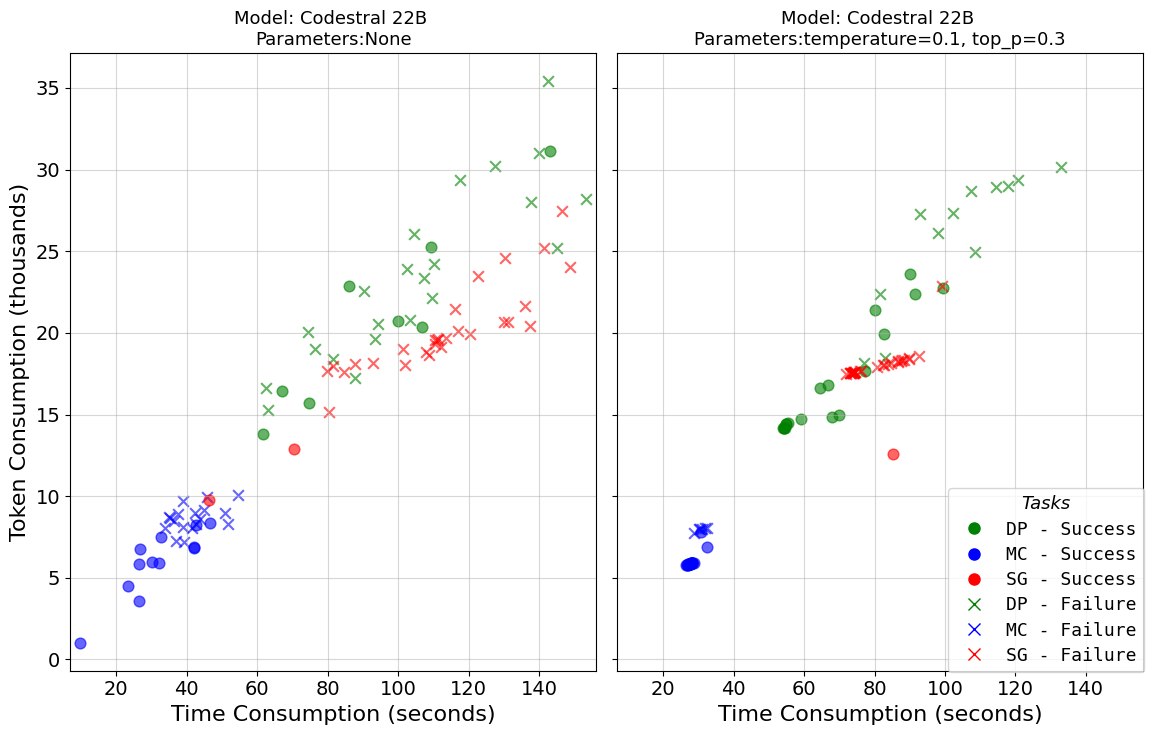

Saved comparison plot -> /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex/scatter_comparison_03.22.pdf


In [37]:
# (Updated) Execute current vs foreign dataset comparison
compare_current_vs_foreign_datasets()

In [38]:
# 7. Calculate and Display Statistics for Each Processor
def calculate_processor_statistics():
    """Calculate average tokens, average time, and success rate for each processor."""
    if not subdir_results:
        print("No data available for statistics calculation.")
        return
    
    # Use the first subdirectory as the main dataset
    current_subdir, current_df, current_batch_info = subdir_results[0]
    
    if current_df.empty:
        print("No data found in current dataset.")
        return
    
    # Add task mapping if not present
    if "task_full_name" not in current_df.columns:
        def map_full_name(bid):
            info = current_batch_info.get(bid)
            return info["full_name"] if info else "Unknown"
        current_df["task_full_name"] = current_df["batch_id"].map(map_full_name)
    
    print("="*80)
    print(f"PROCESSOR STATISTICS - Dataset: {current_subdir}")
    print("="*80)
    
    # Calculate statistics for each processor
    for task_name in ["Data Processor", "Model Converter", "Sketch Generator"]:
        task_data = current_df[current_df["task_full_name"] == task_name]
        
        if task_data.empty:
            print(f"\n{task_name}: No data available")
            continue
            
        # Calculate metrics
        total_runs = len(task_data)
        successful_runs = len(task_data[task_data["status"] == "success"])
        success_rate = (successful_runs / total_runs) * 100 if total_runs > 0 else 0
        
        avg_tokens = task_data["total_tokens"].mean()
        avg_time = task_data["latency"].mean()
        
        # Also calculate metrics for successful runs only
        success_data = task_data[task_data["status"] == "success"]
        if not success_data.empty:
            avg_tokens_success = success_data["total_tokens"].mean()
            avg_time_success = success_data["latency"].mean()
        else:
            avg_tokens_success = 0
            avg_time_success = 0
        
        print(f"\n{task_name}:")
        print(f"  Total Runs: {total_runs}")
        print(f"  Successful Runs: {successful_runs}")
        print(f"  Success Rate: {success_rate:.1f}%")
        print(f"  Average Time (all runs): {avg_time:.2f} seconds")
        print(f"  Average Tokens (all runs): {avg_tokens:,.0f}")
        if success_data.empty:
            print(f"  Average Time (successful only): N/A")
            print(f"  Average Tokens (successful only): N/A")
        else:
            print(f"  Average Time (successful only): {avg_time_success:.2f} seconds")
            print(f"  Average Tokens (successful only): {avg_tokens_success:,.0f}")
    
    print("\n" + "="*80)
    
    # Overall statistics
    total_runs_all = len(current_df)
    successful_runs_all = len(current_df[current_df["status"] == "success"])
    overall_success_rate = (successful_runs_all / total_runs_all) * 100 if total_runs_all > 0 else 0
    
    print(f"OVERALL STATISTICS:")
    print(f"  Total Runs (all processors): {total_runs_all}")
    print(f"  Successful Runs (all processors): {successful_runs_all}")
    print(f"  Overall Success Rate: {overall_success_rate:.1f}%")
    print(f"  Average Time (all runs): {current_df['latency'].mean():.2f} seconds")
    print(f"  Average Tokens (all runs): {current_df['total_tokens'].mean():,.0f}")
    
    success_all = current_df[current_df["status"] == "success"]
    if not success_all.empty:
        print(f"  Average Time (successful runs only): {success_all['latency'].mean():.2f} seconds")
        print(f"  Average Tokens (successful runs only): {success_all['total_tokens'].mean():,.0f}")
    
    print("="*80)

# Execute the statistics calculation
calculate_processor_statistics()

PROCESSOR STATISTICS - Dataset: codestral_87c9

Data Processor:
  Total Runs: 30
  Successful Runs: 8
  Success Rate: 26.7%
  Average Time (all runs): 102.46 seconds
  Average Tokens (all runs): 22,784
  Average Time (successful only): 93.61 seconds
  Average Tokens (successful only): 20,783

Model Converter:
  Total Runs: 30
  Successful Runs: 12
  Success Rate: 40.0%
  Average Time (all runs): 37.70 seconds
  Average Tokens (all runs): 7,561
  Average Time (successful only): 31.75 seconds
  Average Tokens (successful only): 5,952

Sketch Generator:
  Total Runs: 30
  Successful Runs: 2
  Success Rate: 6.7%
  Average Time (all runs): 109.71 seconds
  Average Tokens (all runs): 19,614
  Average Time (successful only): 58.28 seconds
  Average Tokens (successful only): 11,327

OVERALL STATISTICS:
  Total Runs (all processors): 90
  Successful Runs (all processors): 22
  Overall Success Rate: 24.4%
  Average Time (all runs): 83.29 seconds
  Average Tokens (all runs): 16,653
  Average Time

In [39]:
# 8. Generate LaTeX Performance Metrics Table
def generate_latex_performance_table():
    """Generate LaTeX table with performance metrics for each processor."""
    if not subdir_results:
        print("No data available for LaTeX table generation.")
        return
    
    # Use the first subdirectory as the main dataset
    current_subdir, current_df, current_batch_info = subdir_results[0]
    
    if current_df.empty:
        print("No data found in current dataset.")
        return
    
    # Add task mapping if not present
    if "task_full_name" not in current_df.columns:
        def map_full_name(bid):
            info = current_batch_info.get(bid)
            return info["full_name"] if info else "Unknown"
        current_df["task_full_name"] = current_df["batch_id"].map(map_full_name)
    
    # Get model name for the caption
    model_name = extract_model_name(current_batch_info)
    
    # Calculate statistics for each processor
    latex_rows = []
    processor_order = ["Data Processor", "Model Converter", "Sketch Generator"]
    processor_abbrev = {"Data Processor": "DP", "Model Converter": "MC", "Sketch Generator": "SG"}
    
    for task_name in processor_order:
        task_data = current_df[current_df["task_full_name"] == task_name]
        
        if task_data.empty:
            continue
            
        # Calculate metrics
        total_runs = len(task_data)
        successful_runs = len(task_data[task_data["status"] == "success"])
        success_rate = (successful_runs / total_runs) if total_runs > 0 else 0
        
        # Average metrics (all runs)
        avg_time = task_data["latency"].mean()
        avg_tokens = task_data["total_tokens"].mean()
        
        # Format the row
        abbrev = processor_abbrev[task_name]
        row = f"{abbrev} & {avg_tokens:.0f} & {avg_time:.2f} & {success_rate:.3f} \\\\ \\hline"
        latex_rows.append(row)
    
    # Generate the complete LaTeX table
    latex_table = f"""\\begin{{table}}[!h]
    \\centering
    \\begin{{tabular}}{{|l|r|r|r|}}
    \\hline
    Stages & Ave Total Tokens & Ave Execution Time (s) & Success Rate \\\\ \\hline
{chr(10).join(latex_rows)}
    \\end{{tabular}}%
    \\caption{{Performance metrics summary with average execution time, token consumption, and success rate for three stages. Model: {model_name}, Date: {date}}}
    \\label{{tab:performance_summary_{model_name.replace(':', '_')}_{date}}}
    \\end{{table}}"""
    
    # Save to file
    filename = f"tab_performance_summary_{model_name.replace(':', '_')}_{date}.tex"
    output_path = os.path.join(save_dir, filename)
    
    with open(output_path, 'w') as f:
        f.write(latex_table)
    
    print(f"LaTeX table saved to: {output_path}")
    print("\nGenerated LaTeX table:")
    print("="*80)
    print(latex_table)
    print("="*80)

# Execute the LaTeX table generation
generate_latex_performance_table()

LaTeX table saved to: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/03.22/tex/tab_performance_summary_codestral_latest_03.22.tex

Generated LaTeX table:
\begin{table}[!h]
    \centering
    \begin{tabular}{|l|r|r|r|}
    \hline
    Stages & Ave Total Tokens & Ave Execution Time (s) & Success Rate \\ \hline
DP & 22784 & 102.46 & 0.267 \\ \hline
MC & 7561 & 37.70 & 0.400 \\ \hline
SG & 19614 & 109.71 & 0.067 \\ \hline
    \end{tabular}%
    \caption{Performance metrics summary with average execution time, token consumption, and success rate for three stages. Model: codestral:latest, Date: 03.22}
    \label{tab:performance_summary_codestral_latest_03.22}
    \end{table}


### Usage Notes
**Current Functionality:**
1. **Single Dataset Plots**: Original `generate_scatter()` function creates individual scatter plots per dataset
2. **Dataset Comparison**: Set `FOREIGN_DATASET_DIR` and run comparison cells to get side-by-side plots

**Quick Start:**
1. Ensure `processed_data` contains subdirectories with `clean_*_batch.csv` files  
2. Run cells 1-6 to load data and set up plotting functions
3. **For comparison**: Set `FOREIGN_DATASET_DIR = '/path/to/other/dataset'` and run comparison cells
4. Generated PDFs appear in the `tex` directory
5. Adjust colors in Section 4 if needed